# PyMC3 minimal working example and diagnostics
- Python package for Bayesian statistical modeling and Probabilistic Programming;
- Focus on advanced Markov chain Monte Carlo (MCMC) and variational inference (VI) algorithms;
- Great flexibility and direct interaction with the model.

## Useful links
- Get started with [PyMC3](https://docs.pymc.io/notebooks/getting_started)
- PyMC3 parameters [setting](https://docs.pymc.io/api/inference.html)
- PyMC3 [Github](https://github.com/pymc-devs/pymc3)
- PyMC3 [paper](https://peerj.com/articles/cs-55/)

## import X and y
- X: $23,856$ by $12$, the 8th gene has non-zero effect. The 7th and 8th genes are in complete LD.
- y: $23,856$

In [ ]:
import os
import numpy as np, pandas as pd
cwd = os.path.expanduser("~/GIT/cnv-gene-mapping/data/deletion_simu_30_shape0.777_scale0.843")
X = pd.read_csv(f'{cwd}/block_1815_1826/deletion.genes.block30.for_simu.sample.combined.genes.block_1815_1826.gz', compression = "gzip", sep = "\t", header = None, dtype = float)
y = np.loadtxt(f'{cwd}/deletion.genes.block30.for_simu.sample.combined.y.gz', dtype=int)

## Spike and Slab model
Spike-and-Slab Model [link](https://www.kaggle.com/melondonkey/bayesian-spike-and-slab-in-pymc3)

In [2]:
import pymc3 as pm
import theano.tensor as tt
import matplotlib.pyplot as plt

`pi_varbvs`, `mu_varbvs` and `si_varbvs` are from whole genome varbvs.

$\beta_k = (1-\pi_k)\delta_0 + \pi_k N(\mu, \sigma)$
- `pi_varbvs`: $\pi_k$ in spike-and-slab prior
- `mu_varbvs`: $\mu$ in spike-and-slab prior for β$_k$
- `si_varbvs`: $\sigma$ in spike-and-slab prior for β$_k$

In [3]:
pi_varbvs = 0.051366009925488
mu_varbvs = 0.783230896500752
si_varbvs = 0.816999481742865

### Parameters
- iteration: The number of repetition;
- tune_prop: The proportion of tuning to iteration; if iteration = 10000 and tune_prop = 0.25, then tuning number is 2500. Tune means we discard the first n tuning samples; Default is 500 tuning samples.
- n_chain: The number of chains.
- n_core: The number of cores used for sampling.
- target_accept: Adapt the step size such that the average acceptance probability across the trajectories are close to target_accept. Default is 0.8. Higher values for target_accept lead to smaller step sizes.

In [4]:
iteration = 10000
tune_prop = 0.25
seed = 1
n_chain = 10
n_core = 8
target_accept = 0.98

### Model
- Original:

$\beta \sim N(\mu,\sigma)$\
$\alpha \sim U(\text{lower, upper})$, where upper = log$\frac{\text{case prop}}{1-\text{case prop}}$, lower = log$\frac{\text{prevalence}}{1-\text{prevalence}}$

- Reparameterization: If we can't easily make the sampler step-size adjust to the region of space, we can adjust the region of space to make it simpler for the sampler. It can be done with a reparameterization trick. We call this the non-centered version.

$\beta_{\text{offset}} \sim N(0,1)$ \
$\beta = \mu + \sigma * \beta_{\text{offset}}$ \
$\alpha_{\text{offset}} \sim U(-1,1)$ \
$\alpha = \text{lower} + (\alpha_{\text{offset}}+1)/2*(\text{upper}-\text{lower})$

In [5]:
def get_model(y, X, pi0 = pi_varbvs, mu = mu_varbvs, sigma = si_varbvs, prevalence = 0.05, transform = False):
    case_prop = sum(y) / y.shape[0]
    invlogit = lambda x: 1/(1 + tt.exp(-x))
    upper = np.log(case_prop / (1-case_prop))
    lower = np.log(prevalence / (1-prevalence))
    model = pm.Model()
    with model:
        xi = pm.Bernoulli('xi', pi0, shape = X.shape[1]) # inclusion probability for each variable
        # Transformed, non-centered version:
        if transform:
            # reparameterization to non-centered hierarchical model helps with sampling at hierarchical funnel
            beta_offset = pm.Normal('beta_offset', mu = 0, sd = 1, shape = X.shape[1]) # Prior for the non-zero coefficients
            alpha_offset = pm.distributions.continuous.Uniform("alpha_offset", lower = -1, upper = 1)
            beta = pm.Deterministic("beta", mu + beta_offset * sigma)
            alpha = pm.Deterministic("alpha", lower + (alpha_offset+1)/2*(upper - lower))
        # original
        else:
            beta = pm.Normal('beta', mu = mu, sd = sigma, shape = X.shape[1])
            alpha = pm.distributions.continuous.Uniform("alpha", lower = lower, upper = upper)
        p = pm.math.dot(X, xi * beta) # product, Deterministic function to map the stochastics to the output
        y_obs = pm.Bernoulli('y_obs', invlogit(p + alpha), observed = y)  # ??? Data likelihood, logistic regression
    return model

In [6]:
model = get_model(y,X)

In [7]:
model

### Sampling

In [8]:
with model:
    trace1 = pm.sample(draws = iteration, random_seed = seed, cores = min(n_core, n_chain), progressbar = True, chains = n_chain, tune = int(tune_prop*iteration), nuts = {"target_accept": target_accept})

INFO: Multiprocess sampling (10 chains in 8 jobs)

INFO: CompoundStep

INFO: >BinaryGibbsMetropolis: [xi]

INFO: >NUTS: [alpha, beta]

Sampling 10 chains, 0 divergences: 100%|##########| 125000/125000 [2:04:29<00:00, 16.74draws/s] 


WARNING: The acceptance probability does not match the target. It is 0.9378342892557897, but should be close to 0.98. Try to increase the number of tuning steps.

WARNING: The number of effective samples is smaller than 10% for some parameters.

### Results

In [21]:
pd.DataFrame({'inclusion_probability': np.apply_along_axis(np.mean, 0, trace1['xi']),
              'beta': np.apply_along_axis(np.mean, 0, np.multiply(trace1["beta"], trace1["xi"])), # posterior mean of beta
              'beta_given_inclusion': np.apply_along_axis(np.sum, 0, trace1['xi'] * trace1['beta']) / np.apply_along_axis(np.sum, 0, trace1['xi'])
             })

inclusion_probability      beta  beta_given_inclusion
0                 0.11177  0.092618              0.828651
1                 0.11413  0.094732              0.830033
2                 0.11364  0.094342              0.830184
3                 0.07815  0.053763              0.687942
4                 0.07713  0.052372              0.679015
5                 0.05877  0.032074              0.545763
6                 0.52657  1.057585              2.008441
7                 0.54600  1.101239              2.016921
8                 0.02520  0.008466              0.335969
9                 0.02516  0.008418              0.334575
10                0.02406  0.008112              0.337156
11                0.09361  0.070635              0.754562

## MCMC Trace Diagnostics
- PyMC3 MCMC Trace [Diagnostics](https://eigenfoo.xyz/bayesian-modelling-cookbook/#mcmc-trace-diagnostics)
- PyMC3 diagnosing Biased Inference with [Divergences](https://docs.pymc.io/notebooks/Diagnosing_biased_Inference_with_Divergences.html)
- reference [link2](https://calogica.com/pymc3/python/2019/12/08/nfl-4thdown-attempts.html)

$\hat{R}$ (last column of the table): the Gelman–Rubin statistic; the potential scale reduction factor (PSRF); can be interpreted as a convergence diagnostic. It measures how similar the chains are. Ideally it should be close to 1.

PyMC3 includes a handy summary function that provides us with a few key estimates per variable. Aside from mean and the range covered in the hpd (highest posterior density) columns, we also want to make sure `r_hat` is ~1, while the effective sample sizes (ess) per variable are high enough to explore the posterior tails. A low number of effective samples is usually an indication of strong autocorrelation in the chain.

Effective sample sizes for $\beta_6$ and $\beta_7$ are small and their `r_hat`'s are slightly greater than 1.

In [10]:
pm.summary(trace1).round(4)

mean     sd  hpd_3%  hpd_97%  ...   ess_sd  ess_bulk  ess_tail  r_hat
xi[0]     0.112  0.315   0.000    1.000  ...  58350.0   58350.0   58350.0   1.00
xi[1]     0.114  0.318   0.000    1.000  ...  56083.0   56083.0   56083.0   1.00
xi[2]     0.114  0.317   0.000    1.000  ...  56175.0   56175.0   56175.0   1.00
xi[3]     0.078  0.268   0.000    1.000  ...  44374.0   44374.0   44374.0   1.00
xi[4]     0.077  0.267   0.000    1.000  ...  44828.0   44828.0   44828.0   1.00
xi[5]     0.059  0.235   0.000    0.000  ...  26416.0   26416.0   26416.0   1.00
xi[6]     0.527  0.499   0.000    1.000  ...    950.0     950.0     950.0   1.02
xi[7]     0.546  0.498   0.000    1.000  ...    966.0     966.0     966.0   1.02
xi[8]     0.025  0.157   0.000    0.000  ...  45058.0   45058.0   45058.0   1.00
xi[9]     0.025  0.157   0.000    0.000  ...  42739.0   42739.0   42739.0   1.00
xi[10]    0.024  0.153   0.000    0.000  ...  47709.0   47709.0   47709.0   1.00
xi[11]    0.094  0.291   0.000    1.000  ...  61033.0   61033.0   61033.0   1.00
beta[0]   0.790  0.787  -0.693    2.307  ...  71494.0  131869.0   70651.0   1.00
beta[1]   0.785  0.788  -0.688    2.312  ...  74288.0  132510.0   68899.0   1.00
beta[2]   0.791  0.779  -0.682    2.285  ...  73748.0  121943.0   70370.0   1.00
beta[3]   0.777  0.786  -0.704    2.277  ...  77538.0  147393.0   72316.0   1.00
beta[4]   0.782  0.795  -0.726    2.301  ...  73235.0  149623.0   70940.0   1.00
beta[5]   0.771  0.799  -0.750    2.286  ...  68344.0  141787.0   69172.0   1.00
beta[6]   1.428  0.903  -0.280    2.661  ...   1563.0    1844.0   14667.0   1.01
beta[7]   1.462  0.895  -0.263    2.645  ...   1509.0    1787.0   13524.0   1.01
beta[8]   0.773  0.812  -0.762    2.290  ...  74119.0  140689.0   71290.0   1.00
beta[9]   0.770  0.814  -0.754    2.314  ...  76211.0  135363.0   72302.0   1.00
beta[10]  0.772  0.807  -0.720    2.317  ...  72996.0  136175.0   73178.0   1.00
beta[11]  0.779  0.785  -0.699    2.290  ...  71499.0  145912.0   69703.0   1.00
alpha    -0.026  0.012  -0.048   -0.003  ...  67265.0   56859.0   26860.0   1.00

[25 rows x 11 columns]

### Check the traceplot

In [24]:
pm.traceplot(trace1,var_names=('xi[7]', 'beta[7]'))

ExecuteError: [0]: 
---------------------------------------------------------------------------
KeyError                                  Traceback (most recent call last)
script_1772329458133197681 in <module>
----> pm.traceplot(trace1,var_names='xi[7]')
      

KeyError: ['xi[7]'] var names are not present in dataset

In [ ]:
pm.traceplot(trace1,var_names='beta[7]')

### Check if posteriors look reasonable

array([<matplotlib.axes._subplots.AxesSubplot object at 0x7f8d58f60f90>,
      dtype=object)

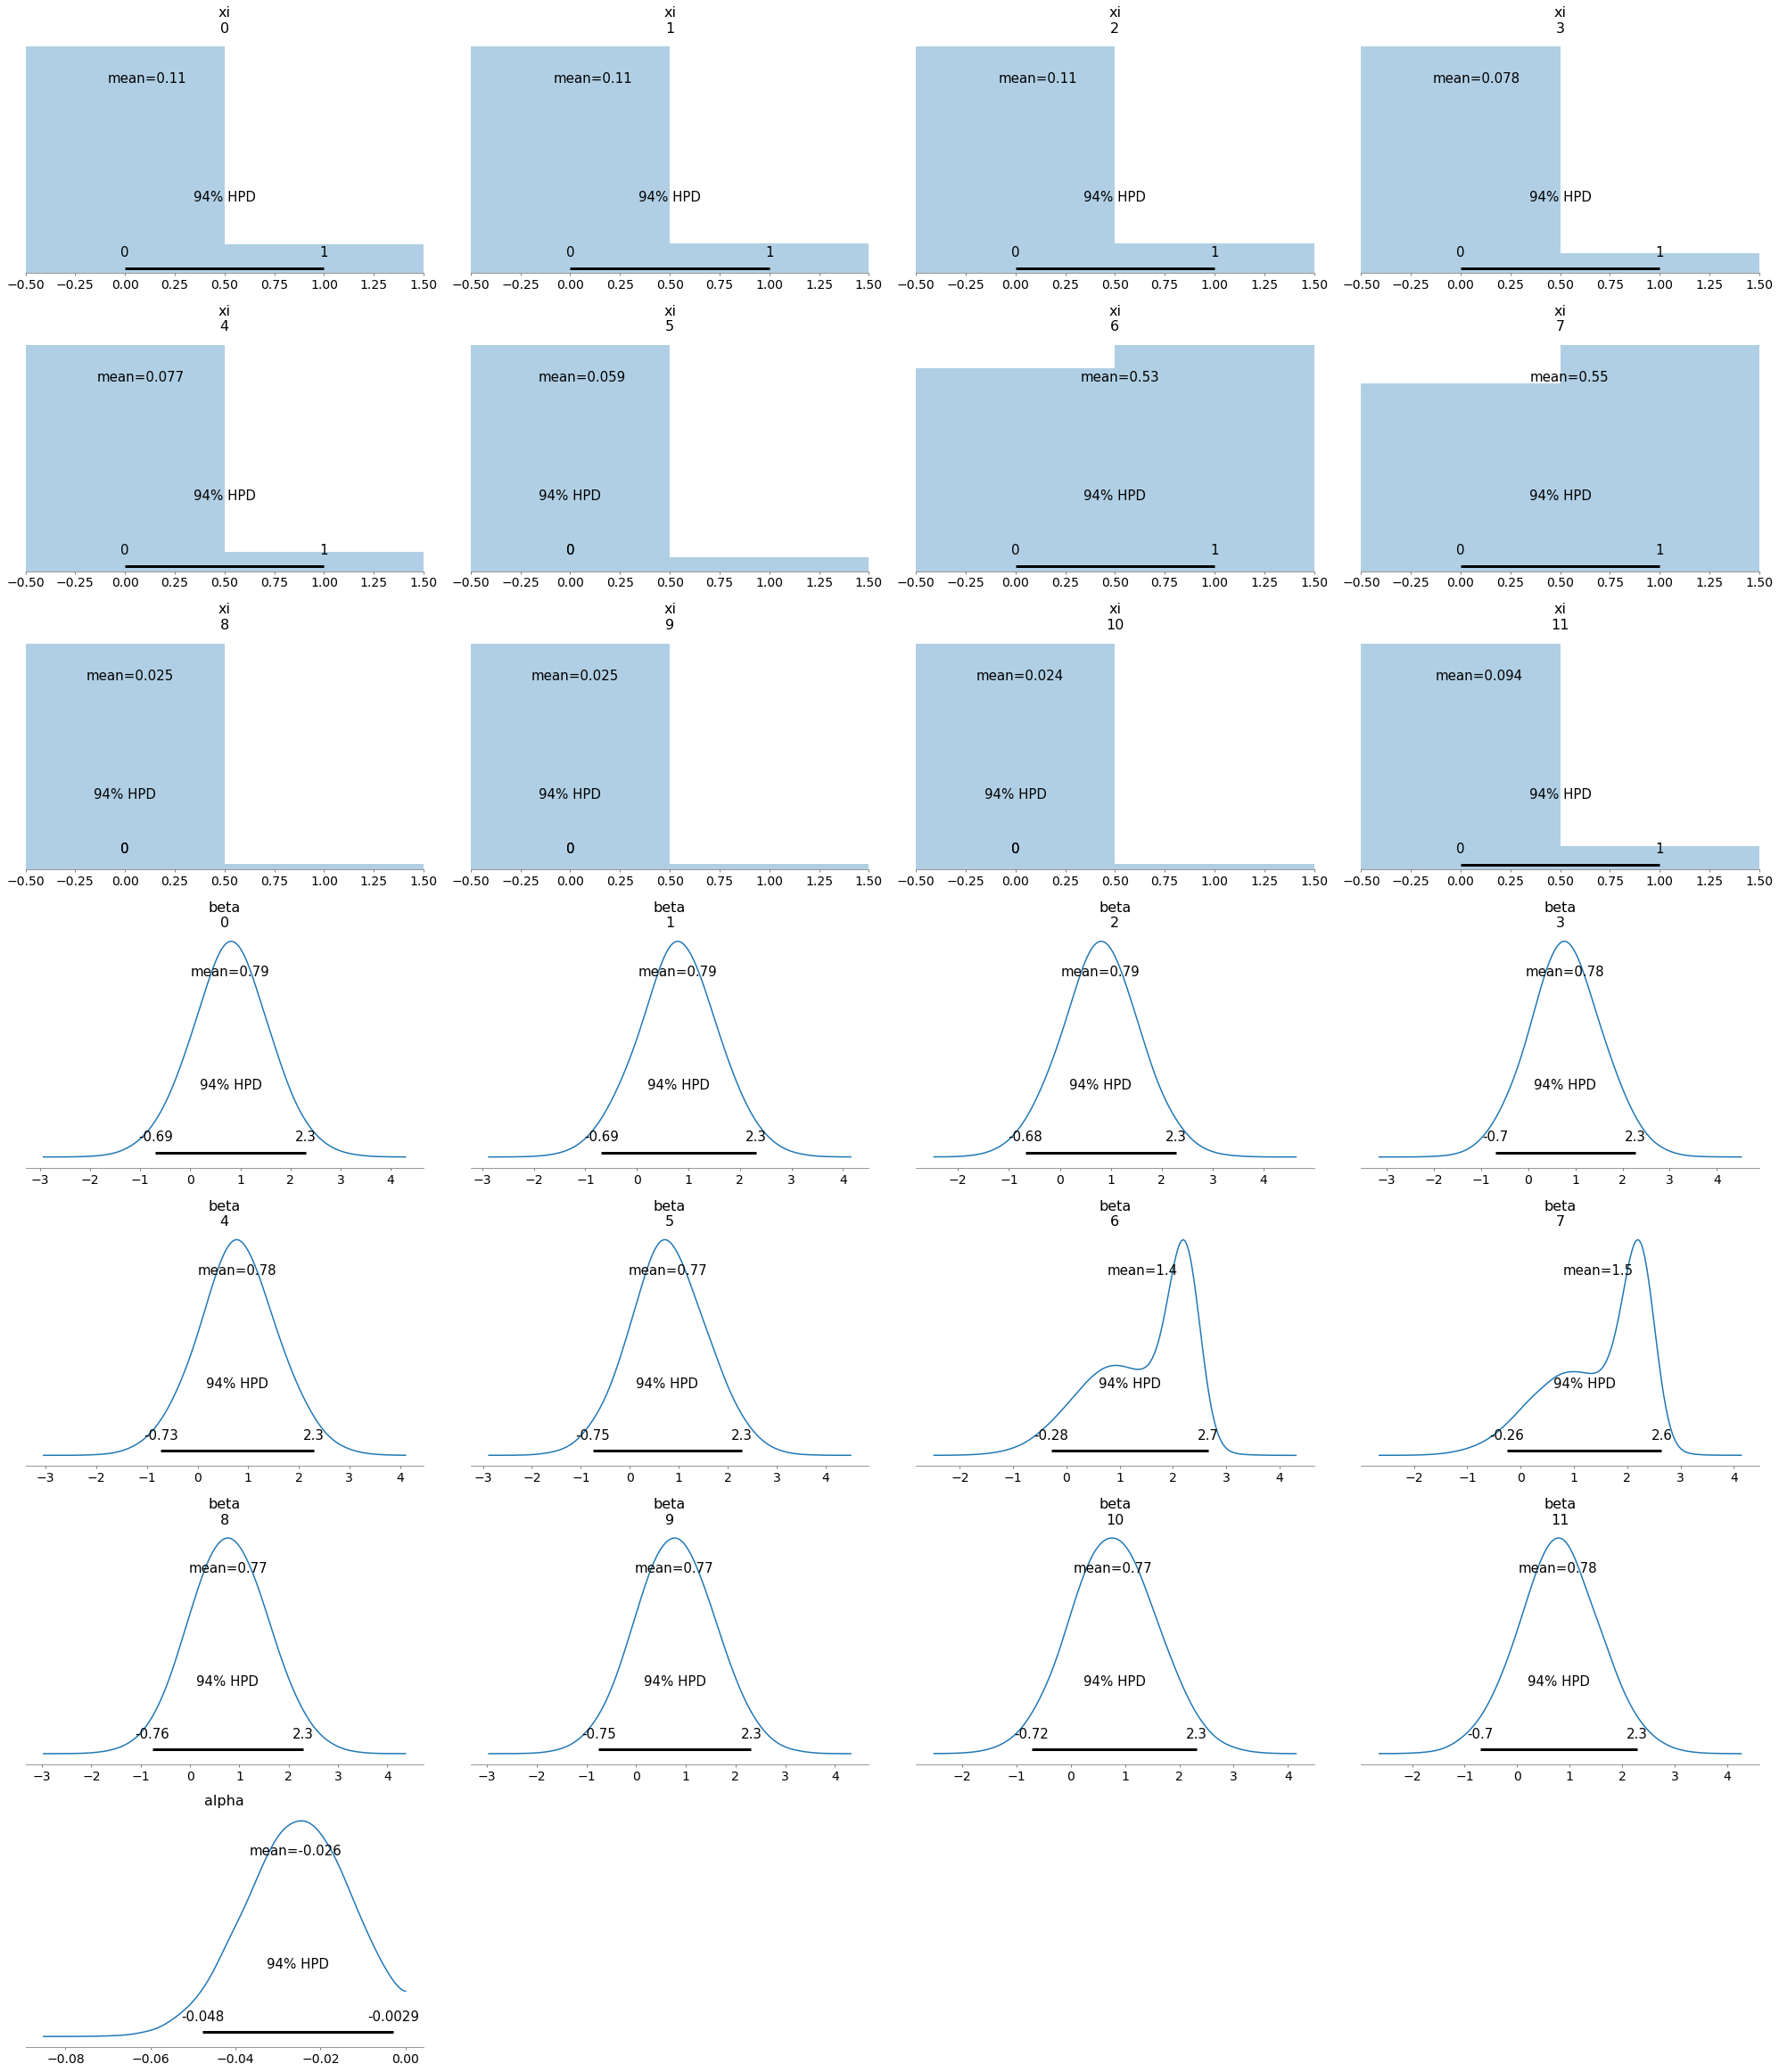

In [12]:
pm.plot_posterior(trace1)

In [13]:
def report_trace(trace):
    beta = trace['beta']
    mbeta = [np.mean(beta[:i]) for i in np.arange(1, len(beta))]
    plt.figure(figsize=(15, 4))
    plt.plot(mbeta, lw=2.5)
    plt.ylim(0.25, 1.5)
    plt.xlabel('Iteration')
    plt.ylabel('MCMC mean of beta')
    plt.title('MCMC estimation of beta')
    plt.show()
    divergent = trace['diverging']
    print('Number of Divergent %d' % divergent.nonzero()[0].size)
    divperc = divergent.nonzero()[0].size / len(trace) * 100
    print('Percentage of Divergent %.1f' % divperc)

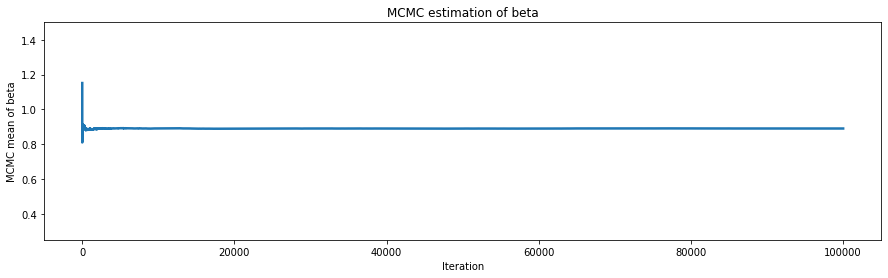

Number of Divergent 0
Percentage of Divergent 0.0


In [14]:
report_trace(trace1)